In [1]:
import sys
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import librosa
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import cv2
import torch
import torchaudio

from tools import prepare, mixup, preprocess, noise, getCorrects

classes = {
    "Unlabeled": 0,
}

2022-12-19 14:29:34.015290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 14:29:34.445273: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 14:29:37.209797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2022-12-19 14:29:37.210087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

# Dataset

In [2]:
num_bands = 257
max_len = 60
seq_len = (max_len + 1) * 2816      # = 250ms ~ 25ms (0.5 * 44 * (512 // 4))
seq_skip = seq_len
patch_len = 44
patch_skip = 22

data_path = "./data/prepared_signal.h5"
X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare(data_path, classes, seq_len, seq_skip)

100%|█████████████████████████████████████████████| 8/8 [00:02<00:00,  3.00it/s]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print("Train sequences:", X_train.shape, Y_train.shape)
print("Test sequences:", X_test.shape, Y_test.shape)
print("Validation sequences:", X_val.shape, Y_val.shape)

Total sequences: 7687
Train sequences: (4612, 171776) (4612, 1)
Test sequences: (1925, 171776) (1925, 1)
Validation sequences: (1150, 171776) (1150, 1)


# Model

In [4]:
import time
import datetime
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary
from torchmetrics.functional import f1_score

from SAM import SAM
from ASL import AsymmetricLoss
from BigBAT import BigBAT

/home/ffundel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ffundel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])

In [6]:
from torchsummary import summary

class EmbedPretrain(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=(3, 5), stride=(2, 3), padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
    
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(2, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=(5, 7), stride=(2, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 3), padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 3), padding=(1, 2)),
            nn.BatchNorm2d(8),
            nn.ReLU(True),

            nn.ConvTranspose2d(8, 1, kernel_size=(2, 3), stride=(2, 3), padding=(3, 5)),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

model = EmbedPretrain().to(device)
summary(model, (1, 44, 257))

In [7]:
batch_size = 32
epochs = 50
lr = 0.001

In [8]:
train_data = TensorDataset(torch.Tensor(X_train), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
val_data = TensorDataset(torch.Tensor(X_val), torch.from_numpy(Y_val))

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [9]:
#criterion = nn.L1Loss()

#optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

criterion = nn.MSELoss() # mean square error loss
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr, 
                             weight_decay=1e-5) # <--
    
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=5)
scheduler = None

min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

In [10]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs = inputs.to(device)
        inputs = preprocess(inputs)
        
        inputs = inputs.unfold(dimension=1, size=patch_len, step=patch_skip).permute((0, 1, 3, 2)) # patches
        b, n, w, h = inputs.shape
        inputs = inputs.reshape((b * n, 1, w, h))
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(inputs)

        # Compute Loss
        loss = criterion(outputs, inputs)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
    
        # Perform learning rate step
        #scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    
    return epoch_loss

In [11]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0

        for batch, (inputs, labels) in enumerate(tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs = inputs.to(device)
            inputs = preprocess(inputs)
            
            inputs = inputs.unfold(dimension=1, size=patch_len, step=patch_skip).permute((0, 1, 3, 2)) # patches
            b, n, w, h = inputs.shape
            inputs = inputs.reshape((b * n, 1, w, h))
            num_samples = b * n
        
            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, inputs)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / num_samples
    
    a = np.random.randint(0, num_samples, 5)
    return epoch_loss, inputs[a], outputs[a]

# Training

In [12]:
import wandb

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size
}

wandb.init(project="BigBAT-pretrain", entity="frankfundel", config=wandb_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)
2022-12-19 14:30:35.374358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 14:30:35.813919: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 14:30:37.987092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory

==================== Starting at epoch 0 ====================


100%|█████████████████████████████████████████| 145/145 [00:56<00:00,  2.58it/s]

Training loss: 0.1744



100%|███████████████████████████████████████████| 36/36 [00:03<00:00, 10.95it/s]


Validation loss: 0.1537


../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [114,0,0], thread: [32,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [114,0,0], thread: [33,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [114,0,0], thread: [34,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [114,0,0], thread: [35,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [114,0,0], thread: [36,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [114,0,0], thread: [37,0,0] Assertion 

TypeError: Invalid shape (44, 60, 257) for image data

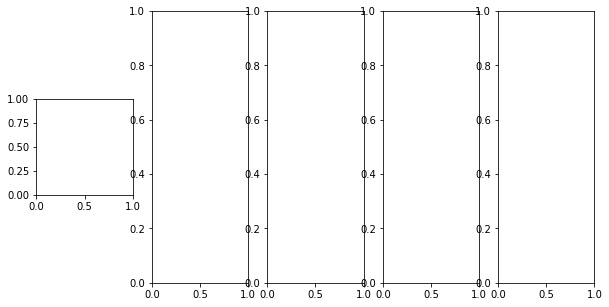

In [13]:
show_out = True

for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f}'.format(train_loss), flush=True)
    
    val_loss, ins, outs = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f}'.format(val_loss), flush=True)
    
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
    })
    
    if show_out:
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
        for img, ax in zip(ins, axs):
            ax.imshow(torch.rot90(img.cpu().squeeze(0)))
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 5))
        for img, ax in zip(outs, axs):
            ax.imshow(torch.rot90(img.cpu().squeeze(0)))
        plt.show()
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(model.state_dict(), 'BigBAT-UFS-EAE.pth')

# Load after training
model.load_state_dict(torch.load('BigBAT-UFS-EAE.pth'))

# Evaluation